# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
%matplotlib notebook
# Change notebook to widget if you use jupyter lab

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

In [2]:
X_raw, Y = get_data_set()
X_raw.shape, Y.shape

((285,), (285,))

## What the data looks like ?

<IPython.core.display.Javascript object>


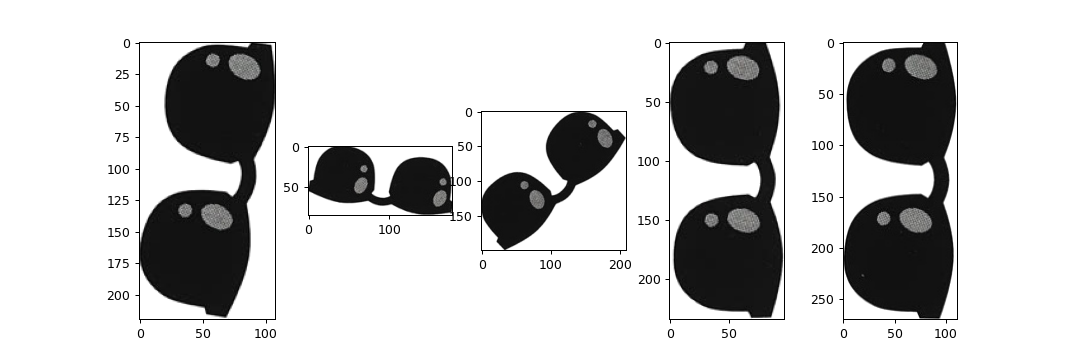

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [3]:
nb_class = np.max(Y)
_, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, x in enumerate(X_raw[Y == class_]):
        ax_arr[i].imshow(x)

## Apply median filter to reduce noise on printed images

In [4]:
X = np.array([cv2.medianBlur(img, 3, 0) for img in X_raw], dtype=object)

## What the data looks like ?

<IPython.core.display.Javascript object>


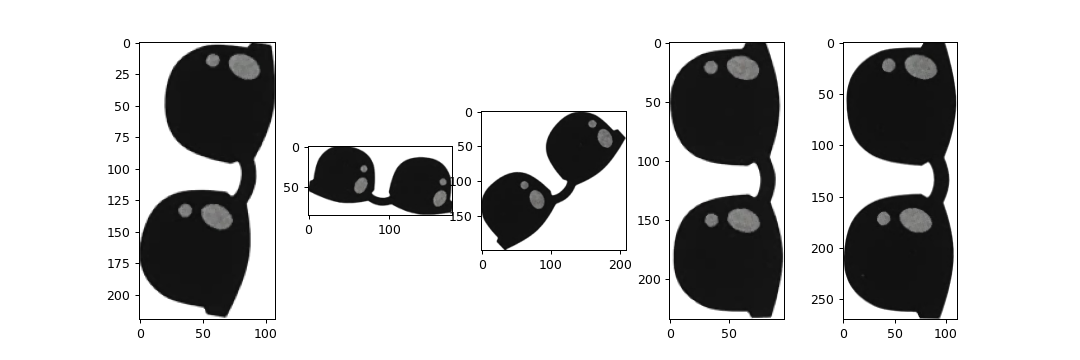

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [5]:
nb_class = np.max(Y)
_, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

# Color reduction

## Better Image mask

On prend en compte tous les pixels à l'intérieur des formes

<IPython.core.display.Javascript object>


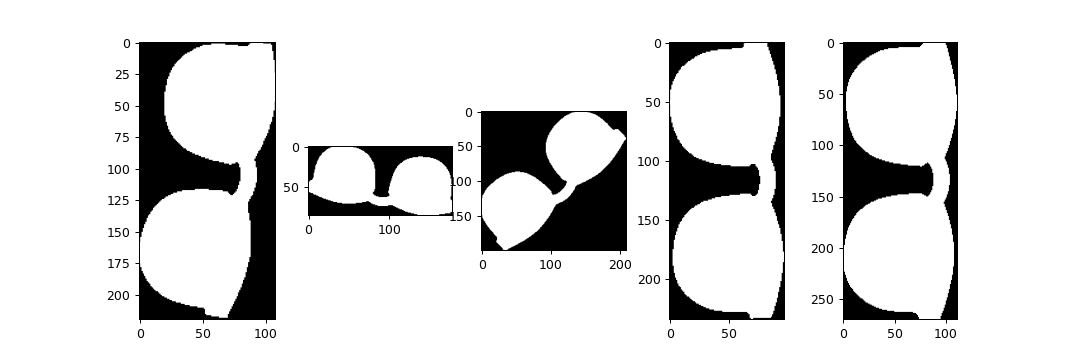

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [6]:
from dobble_master_race.img_utils import mask_with_inner

masks = np.array([mask_with_inner(img, 240) for img in X], dtype=object)
_, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

## Sampling pixels

In [7]:
nb_sample = 50000

nb_images = nb_class * 5
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Visualize sampled pixels

<IPython.core.display.Javascript object>


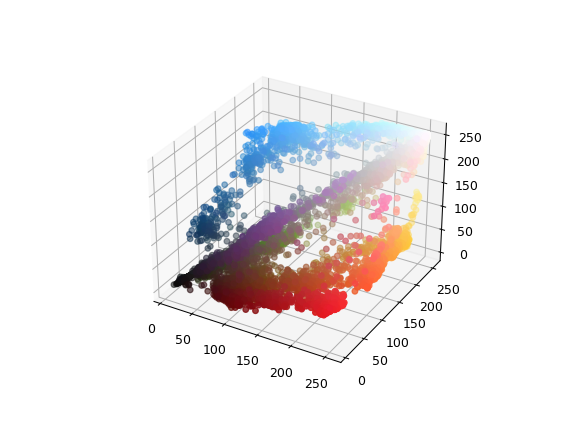

In [8]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))

disp_pxls = sample_pxls[np.random.choice(sample_pxls.shape[0], size=10000, replace=False)]
_ = ax.scatter3D(disp_pxls[:, 0], disp_pxls[:, 1], disp_pxls[:, 2], c = disp_pxls / 255)

## Selecting color quantization threshold

In [9]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_range = (2, 21)

# Compute new_colors and inertias
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:35<00:00,  1.85s/it]


<IPython.core.display.Javascript object>


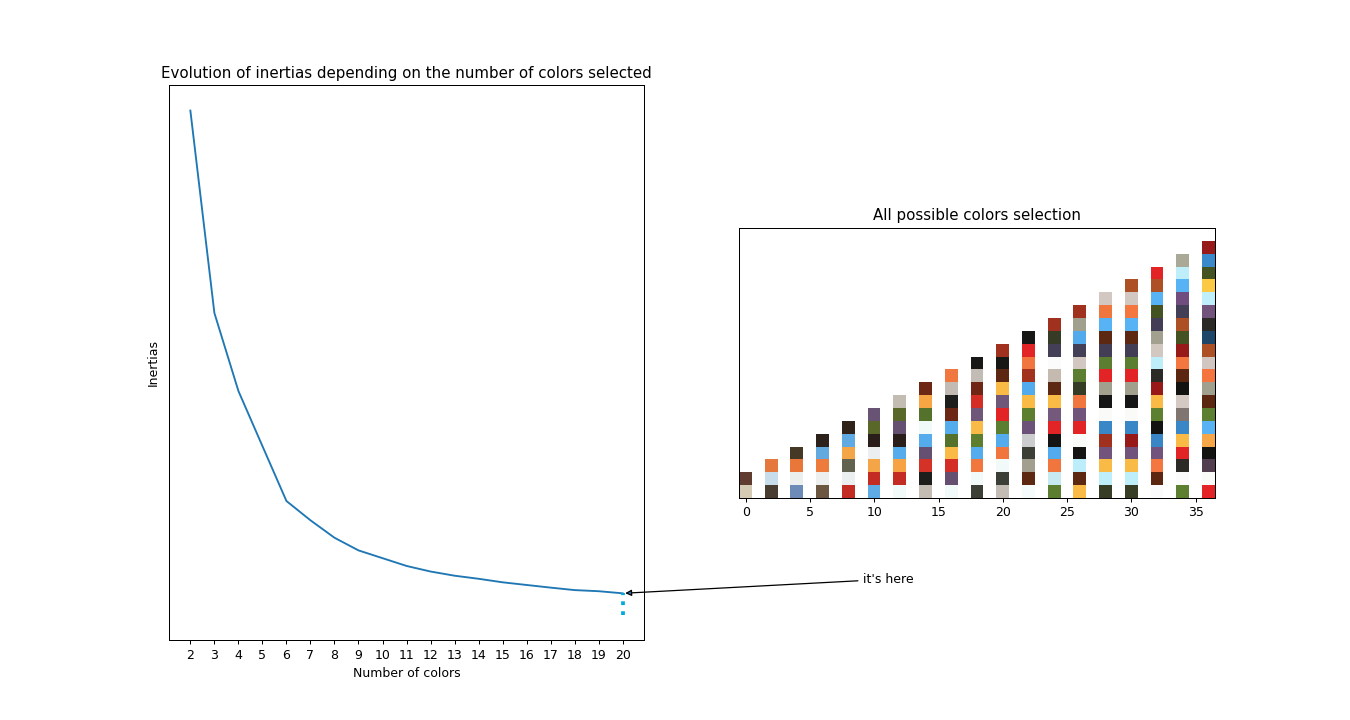

In [10]:
nb_opti_color = 20
_, ax_arr = plt.subplots(ncols=2, figsize=(15,8))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = new_color[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("All possible colors selection")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias depending on the number of colors selected")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"it's here", xy=(nb_opti_color, inertias[nb_opti_color - color_range[0]]),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"));

<IPython.core.display.Javascript object>


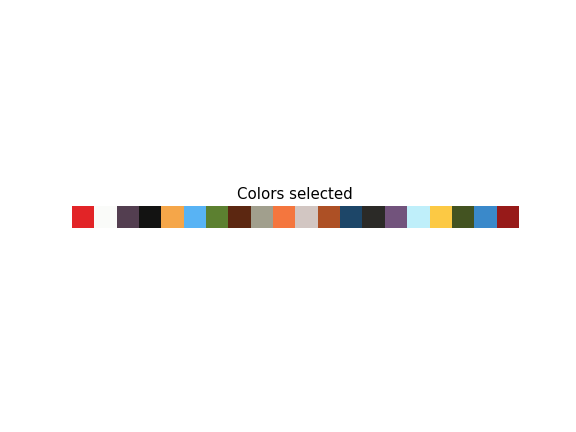

In [11]:
# Example of color sampling
nb_color = nb_opti_color

kmeans = KMeans(n_clusters=nb_color, random_state=42)
kmeans.fit(sample_pxls)
new_color_lut = kmeans.cluster_centers_.astype(np.uint8)

_, ax = plt.subplots()
_ = ax.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

<IPython.core.display.Javascript object>


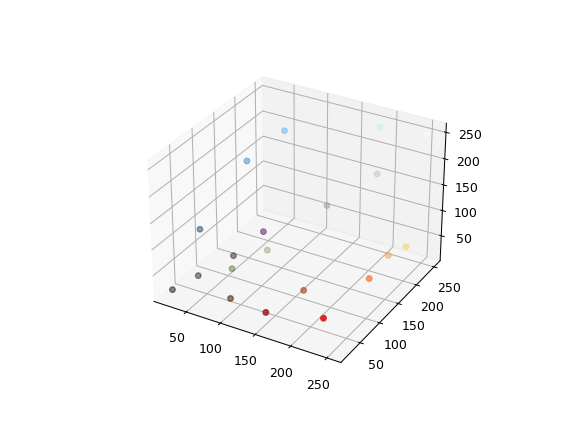

In [12]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))

ax.scatter3D(new_color_lut[:, 0], new_color_lut[:, 1], new_color_lut[:, 2], c = new_color_lut / 255)

<IPython.core.display.Javascript object>


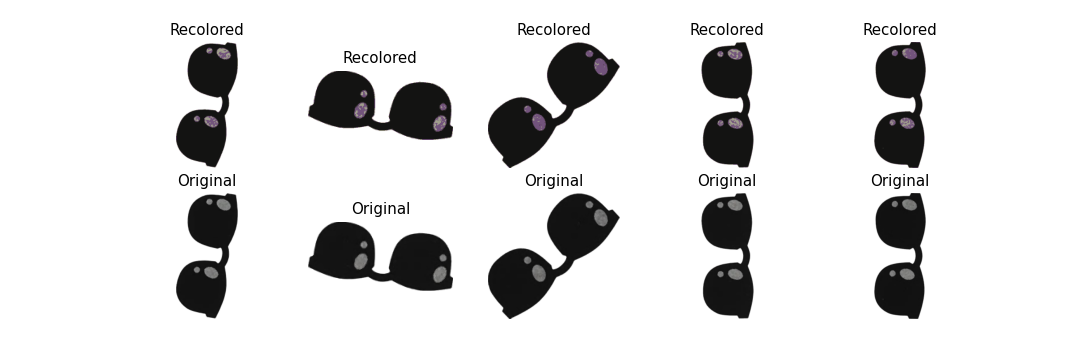

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [13]:
color_maps = np.array([
    kmeans.predict(img[mask])
    for img, mask in zip(X, masks)
], dtype=object)

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

recolored_X = np.array([
    get_recolored_img(img, mask, color_map)
    for img, mask, color_map in zip(X, masks, color_maps)
], dtype=object)

_, ax_arr = plt.subplots(nrows=2, ncols=5, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_arr[0, i].imshow(recolored_x)
        ax_arr[1, i].imshow(x)
        ax_arr[0, i].axis("off"); ax_arr[0, i].set_title("Recolored")
        ax_arr[1, i].axis("off"); ax_arr[1, i].set_title("Original")

## Compute the color histograms

In [14]:
def get_hist(color_map: np.array) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / hist.max()
    
    return norm_hist

color_histograms = np.array([get_hist(color_map) for color_map in color_maps], dtype=object)
color_histograms[0]

array([0.0, 0.3955902709116077, 0.02837650781095511, 0.0,
       0.012952343286533517, 0.0, 0.0018785841407949378, 1.0,
       0.040438995451848925, 0.8870872058532727, 0.22236503856041132,
       0.4668775954122998, 0.0, 0.02372948388372553, 0.023927229582756573,
       0.0006921099466086612, 0.0, 0.002372948388372553, 0.0,
       0.0678267747676488], dtype=object)

<IPython.core.display.Javascript object>


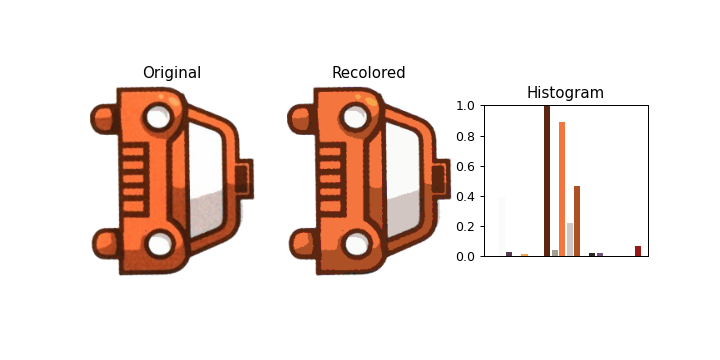

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

In [15]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

_, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    ax_arr[0].imshow(X[x_index])
    ax_arr[0].set_axis_off()
    ax_arr[0].set_title("Original")

    ax_arr[1].imshow(recolored_X[x_index])
    ax_arr[1].set_axis_off()
    ax_arr[1].set_title("Recolored")
    
    #plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    ax_arr[2].clear()
    ax_arr[2].set_ylim(0, 1)
    ax_arr[2].set_aspect(nb_color)
    ax_arr[2].bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    ax_arr[2].set_xticks([])
    ax_arr[2].set_title("Histogram")

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [16]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [17]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [18]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

<IPython.core.display.Javascript object>


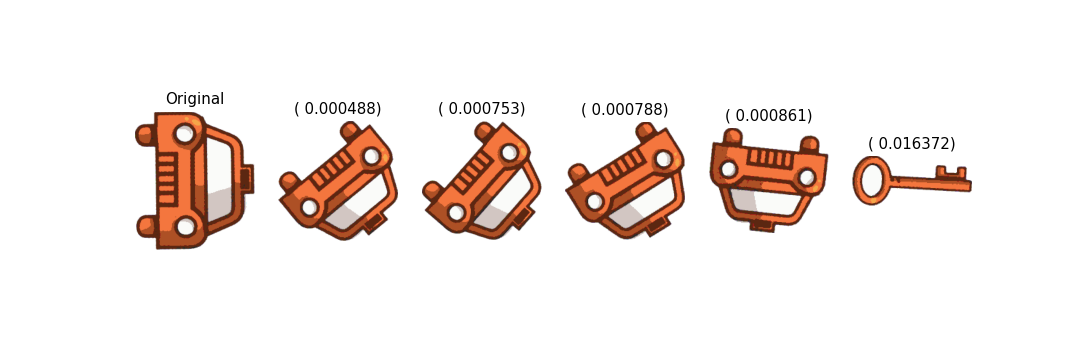

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

In [19]:
nb_images_displayed = 5
nb_columns = nb_images_displayed + 1

_, ax_arr = plt.subplots(nrows=1, ncols=nb_columns, figsize=(12,4))

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    ax_arr[0].imshow(recolored_X[x_index])
    ax_arr[0].set_axis_off()
    ax_arr[0].set_title("Original")
    
    for img_id in range(1, nb_columns):
        idx = idx_of_best_matches_per_row[x_index, img_id - 1]
        ax_arr[img_id].imshow(recolored_X[idx])
        ax_arr[img_id].set_axis_off()
        ax_arr[img_id].set_title(f"({dist_mat[x_index, idx]: .6f})")

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

# Classifier base on image color histogram

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_validate

In [21]:
def evaluate_classifier(clf, X, Y):
    val_dict = cross_validate(clf, X, Y, cv=5, return_estimator=True)
    scores = val_dict["test_score"]
    estimators = val_dict["estimator"]
    
    return scores, estimators, estimators[np.argmax(scores)]

In [22]:
svc_scores, _, best_svc = evaluate_classifier(SVC(), color_histograms, Y)

print("SVC scores:", svc_scores)

SVC scores: [0.98245614 1.         0.98245614 0.98245614 0.96491228]


In [23]:
knn_scores, _, best_knn = evaluate_classifier(KNeighborsClassifier(), color_histograms, Y)

print("SVC scores:", knn_scores)

SVC scores: [0.98245614 0.98245614 1.         0.98245614 0.96491228]


In [24]:
rnd_scores, _, best_rnd = evaluate_classifier(RandomForestClassifier(max_depth=10), color_histograms, Y)

print("SVC scores:", rnd_scores)

SVC scores: [0.98245614 0.96491228 0.96491228 0.98245614 0.98245614]


In [25]:
dummy_scores, _, best_dummy = evaluate_classifier(DummyClassifier(strategy='uniform'), color_histograms, Y)

print("Dummy scores:", dummy_scores)

Dummy scores: [0.03508772 0.05263158 0.03508772 0.01754386 0.        ]


In [26]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    plt.figure(figsize=(11, 10))
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()

<IPython.core.display.Javascript object>


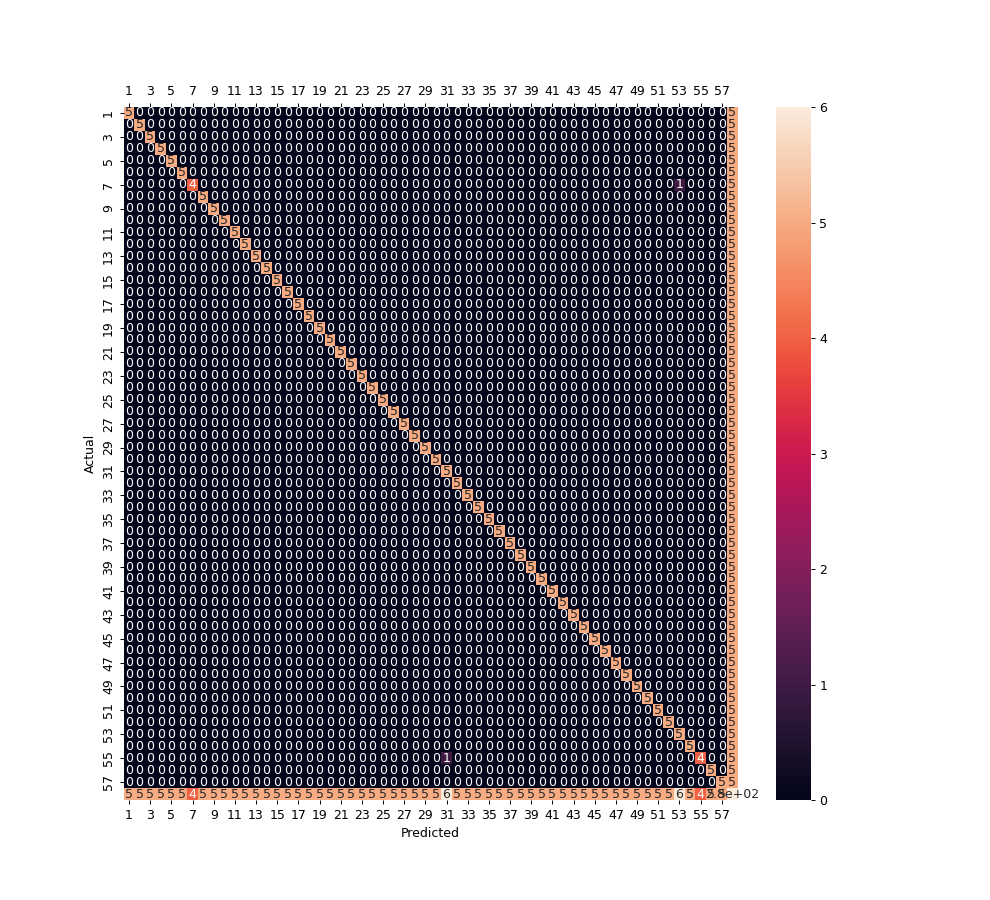

In [27]:
print_confusion_matrix(best_knn.predict(color_histograms), Y)

<IPython.core.display.Javascript object>


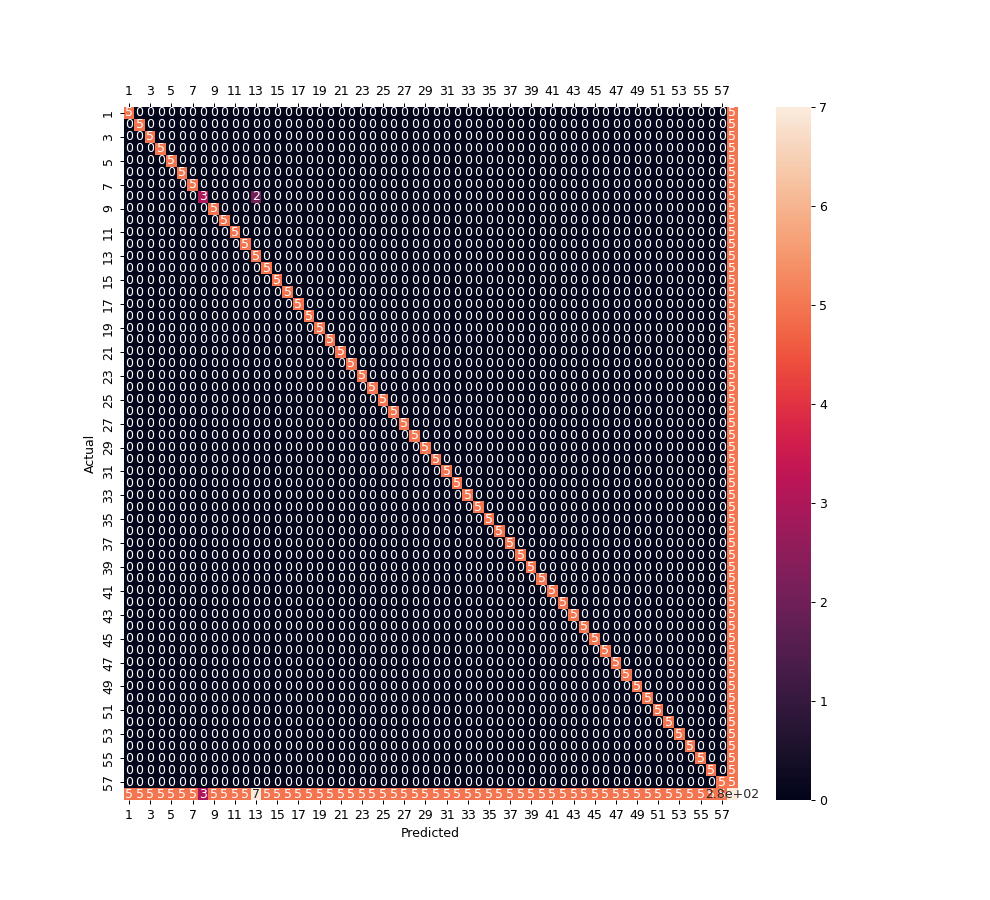

In [28]:
print_confusion_matrix(best_svc.predict(color_histograms), Y)

<IPython.core.display.Javascript object>


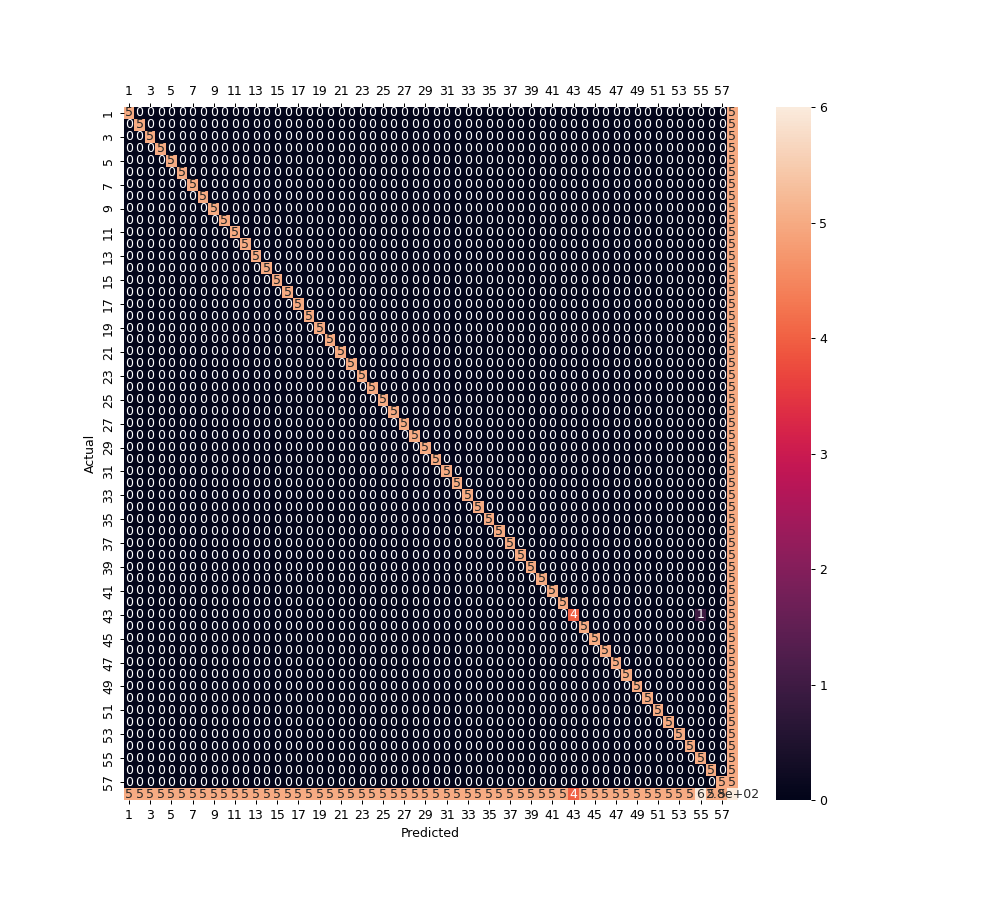

In [29]:
print_confusion_matrix(best_rnd.predict(color_histograms), Y)

<IPython.core.display.Javascript object>


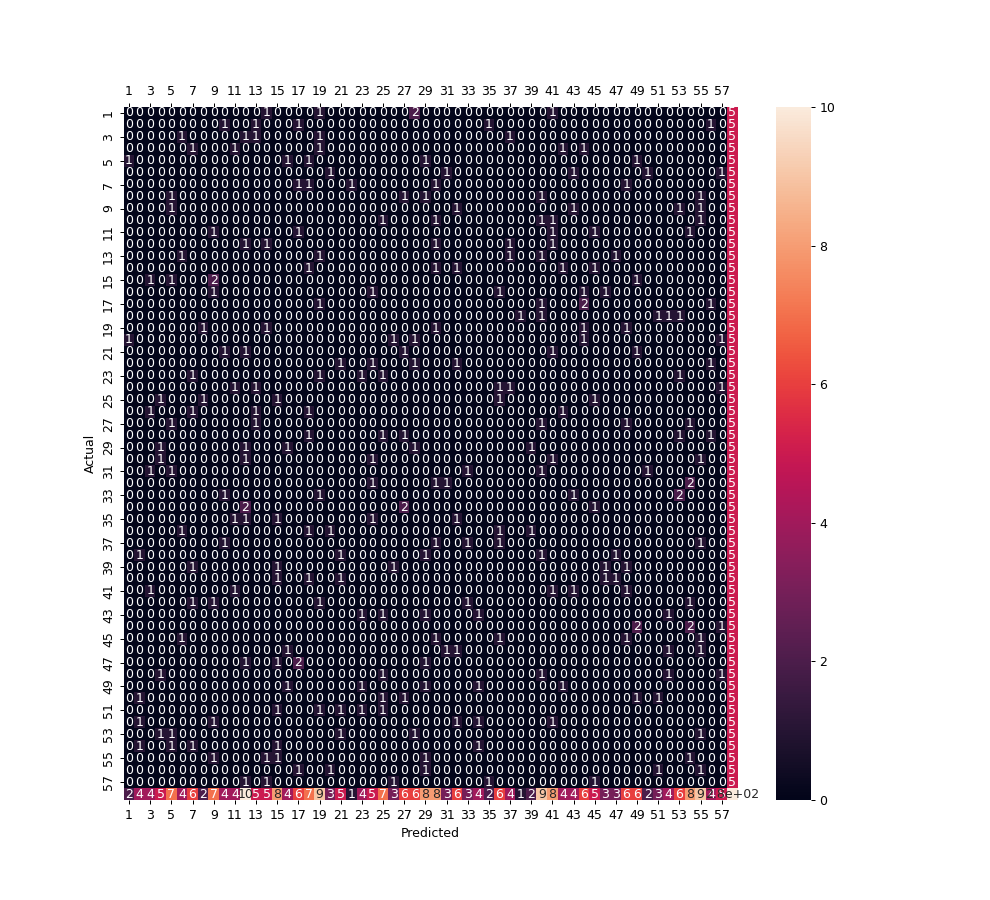

In [30]:
print_confusion_matrix(best_dummy.predict(color_histograms), Y)